### Classification with Pytorch

In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
from sklearn.datasets import make_circles

In [5]:
X,y=make_circles(1000,noise=0.03,random_state=42)
len(X),len(y)

(1000, 1000)

In [7]:
X[:5] # 2 input features because its a circle dataset where with help of X1,X2 we create a circle of radius y

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [9]:
df=pd.DataFrame(
                {'X1':X[:,0],
                 'X2':X[:,1],
                 'labels':y}
               )

In [10]:
df.head(3)

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1


In [14]:
df.labels.value_counts()

1    500
0    500
Name: labels, dtype: int64

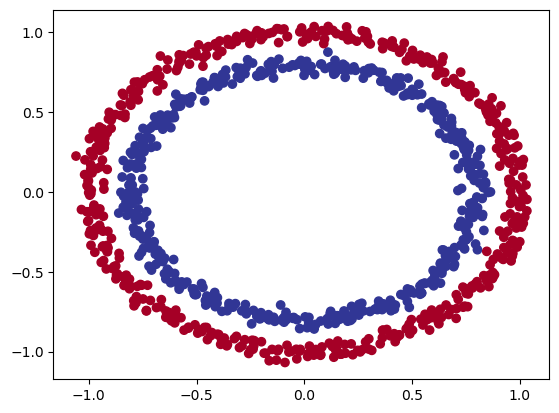

In [21]:
# Visualize, Visualize, visualize here!!
plt.scatter(x=df['X1'],y=df['X2'],c=y,cmap=plt.cm.RdYlBu)
plt.show()

In [8]:
# splitting the data
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,y,random_state=42,test_size=0.2)

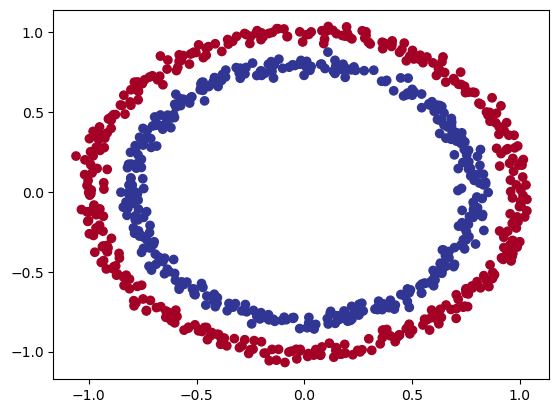

In [28]:
#Visualizing the ttrain and test data
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap='RdYlBu')
plt.show()

In [29]:
# Next Steps 
# 1. Device agnnostic code
# 2. Move train and test data to gpu by creating Tensors
# 3. Build Model Architecture
# 4.Training loop
# 5.Tetsing

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device

'mps'

In [64]:
loop=['X_train','X_test','Y_train','Y_test']
for l in loop:
    m=locals()[l]
    if isinstance(m, np.ndarray):
        locals()[l]=torch.from_numpy(m).type(torch.float).to(device)
X_train.device

device(type='mps', index=0)

In [67]:
torch.__version__

'2.0.1'

### Circular Model -Linear 

In [141]:
# Model Architecture and moving the instance into gpu
class CircularModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1=nn.Linear(in_features=2,out_features=8)
        self.linear_2=nn.Linear(in_features=8,out_features=1)
    def forward(self,x):
        x=self.linear_1(x)
        return self.linear_2(x)
    
c_model_0=CircularModelV0().to(device)
c_model_0

CircularModelV0(
  (linear_1): Linear(in_features=2, out_features=8, bias=True)
  (linear_2): Linear(in_features=8, out_features=1, bias=True)
)

In [75]:
next(c_model_0.parameters()).device,device

(device(type='mps', index=0), 'mps')

In [79]:
# other way to build model is simple and easy method using nn.Sequential
#Used when their is no complexity while passing models is passes seqeunce give the layers
model_s_0=nn.Sequential(
                nn.Linear(in_features=2,out_features=8),
                nn.Linear(in_features=8,out_features=1)
    ).to(device)
model_s_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [80]:
next(model_s_0.parameters()).device

device(type='mps', index=0)

In [83]:
model_s_0.state_dict() # weight parameters are created according the in & out features
# We can see the both ways of model creating either thr class and sequential created the same way
# we can replace them if we wanted to , but class method is preferred for all cases.

OrderedDict([('0.weight',
              tensor([[-0.5137, -0.1220],
                      [ 0.6313,  0.2791],
                      [-0.2456, -0.3126],
                      [ 0.5640, -0.6171],
                      [ 0.1829, -0.0289],
                      [ 0.5638, -0.3413],
                      [-0.2320,  0.4485],
                      [ 0.3632, -0.5285]], device='mps:0')),
             ('0.bias',
              tensor([-0.6755,  0.6932,  0.6324,  0.2879, -0.5656, -0.0238,  0.0723,  0.0772],
                     device='mps:0')),
             ('1.weight',
              tensor([[-0.2792, -0.0986,  0.0005,  0.0661, -0.2224, -0.1807,  0.1404,  0.0456]],
                     device='mps:0')),
             ('1.bias', tensor([0.3051], device='mps:0'))])

In [87]:
# Seeing the result without training the model just with intial params
with torch.inference_mode():
    untrained_preds=model_s_0(X_test)
print(f'preds untrained:{torch.round(untrained_preds[:5])}')
print(f'preds Actual:{Y_test[:5]}')

preds untrained:tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0')
preds Actual:tensor([1., 0., 1., 0., 1.], device='mps:0')


In [52]:
# defining accuracy fn
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=correct*100/len(y_true)
    return acc

In [90]:
# Model Architecture done then we go for optimizer and Loss fn
# For Loss fn we may use BCEWithLogitLoss() or BinaryCrossEntroppyLoss
# 1.Main diff bw two is BCELogit expects a raw input from our model
# 2. But our BCEcrossentropy expects a probabilistic loss as a input .So output from the 
# model need to pass thro sigmoid fn before passing into BCE
# To visulize we need to round the sigmoid out >0.5 to 0 like that
# So Inshort : logit(modeloutput) -> sigmoid(probabilistic) -> torch.round->(class labels) 
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=c_model_0.parameters(),lr=0.1)

In [116]:
#seeing how good our model performs before
c_model_0.eval()
with torch.inference_mode():
    y_logit=c_model_0(X_test)
y_untest=torch.sigmoid(y_logit)
y_untest=torch.round(y_untest).squeeze()
y_untest

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='mps:0')

In [117]:
accuracy_fn(Y_test,y_untest)

50.0

#### Training Loop

In [156]:
# Training the model with linear activation
c_model_0.to(device)
EPOCHS=100
for epoch in range(EPOCHS):
    c_model_0.train()
    preds_logit=c_model_0(X_train).squeeze(dim=1)
    y_pt=torch.round(torch.sigmoid(preds_logit))
    acc_train=accuracy_fn(Y_train,y_pt)
    loss=loss_fn(preds_logit,Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    c_model_0.eval()

    with torch.inference_mode():
        y_logit_test=c_model_0(X_test).squeeze(dim=1)
    y_p=torch.round(torch.sigmoid(y_logit_test))
    loss_test=loss_fn(y_logit_test,Y_test)
    acc=accuracy_fn(Y_test,y_p)
    
    if(epoch%10==0):
        print(f'Train loss:{loss:.4f},Train Accuracy:{acc_train:.2f} | Test loss{loss_test:.4f}, Test Accuracy:{acc:.2f}')


Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00
Train loss:0.6999,Train Accuracy:50.00 | Test loss0.6984, Test Accuracy:50.00


In [143]:
preds=c_model_0(X_train).squeeze(dim=1)
preds[:10]

tensor([-0.1588, -0.1372, -0.2421, -0.2322, -0.2914, -0.2093, -0.2901, -0.2424,
        -0.3036, -0.1470], device='mps:0', grad_fn=<SliceBackward0>)

In [144]:
# Model performed utterly bad if we wannted to visualize we plot what model thinking with plot_model_code
# To do that we need some functions which we need to borrow from github with request module

In [146]:
import requests
from pathlib import Path

#Downloading the helper function from the github raw data
if Path('helper_functions.py').is_file():
    print('Skiiping the downloading the file , since it already exists')
else:
    print('Downloading the file from github')
    request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py','wb') as f:
        f.write(request.content)
    print('Downloaded and saved the file')
from helper_functions import *

Skiiping the downloading the file , since it already exists


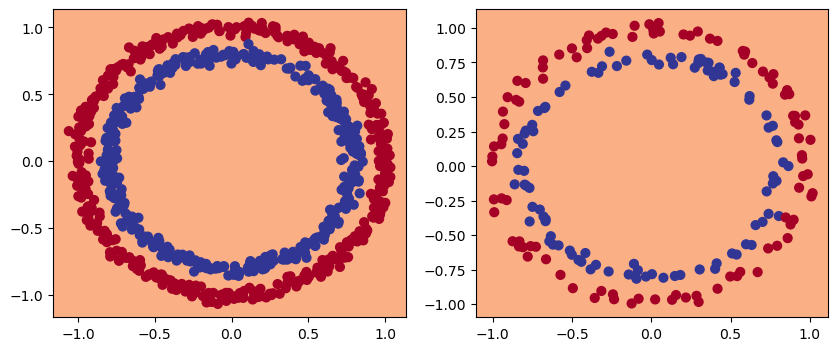

In [157]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_decision_boundary(c_model_0,X_train,Y_train)
plt.subplot(1,2,2)
plot_decision_boundary(c_model_0,X_test,Y_test)

### Buildin Non-Linear Model Architecture

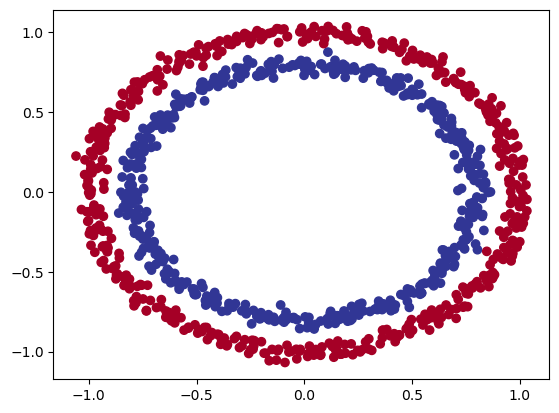

In [87]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X,y=make_circles(1000,random_state=42,noise=0.03)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)
plt.show()

In [88]:
device='cuda' if torch.cuda.is_available() else 'mps'
device

'mps'

In [90]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=42)
loop=['X_train','X_test','Y_train','Y_test']
for l in loop:
    m=locals()[l]
    if isinstance(m, np.ndarray):
        locals()[l]=torch.from_numpy(m).type(torch.float).to(device)
X_train.device

device(type='mps', index=0)

In [96]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=correct*100/len(y_true)
    return acc

In [106]:
class circularNonLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1=nn.Linear(in_features=2,out_features=8)
        self.linear_2=nn.Linear(in_features=8,out_features=10)
        self.linear_3=nn.Linear(in_features=10,out_features=1)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.linear_3(self.relu(self.linear_2(self.relu(self.linear_1(x)))))
model_2=circularNonLinear()
model_2.to(device)
model_2

circularNonLinear(
  (linear_1): Linear(in_features=2, out_features=8, bias=True)
  (linear_2): Linear(in_features=8, out_features=10, bias=True)
  (linear_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
next(model_2.parameters()).device

In [107]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.1)

In [108]:
X_train,X_test,Y_train,Y_test=X_train.to(device),X_test.to(device),Y_train.to(device),Y_test.to(device)
X_train.device

device(type='mps', index=0)

In [109]:
EPCHOS=1000
for epoch in range(EPCHOS):
    model_2.train()
    predsltr=model_2(X_train).squeeze()
    y_pre=torch.round(torch.sigmoid(predsltr))
    acc=accuracy_fn(Y_train,y_pre)
    loss=loss_fn(predsltr,Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch%100==0):
        with torch.inference_mode():
            predsltest=model_2(X_test).squeeze()
        preds=torch.round(torch.sigmoid(predsltest))
        test_loss=loss_fn(predsltest,Y_test)
        acctest=accuracy_fn(Y_test,preds)
        print(f'Train Loss: {loss}, Train Acc:{acc} | Test Loss:{test_loss}, Test Accuracy{acctest}')

Train Loss: 0.6965718865394592, Train Acc:50.875 | Test Loss:0.6990785598754883, Test Accuracy51.5
Train Loss: 0.690263569355011, Train Acc:51.5 | Test Loss:0.6917980909347534, Test Accuracy52.5
Train Loss: 0.6869555711746216, Train Acc:55.25 | Test Loss:0.6888551115989685, Test Accuracy54.5
Train Loss: 0.6826894879341125, Train Acc:65.5 | Test Loss:0.6854821443557739, Test Accuracy63.5
Train Loss: 0.6770954132080078, Train Acc:63.875 | Test Loss:0.6810764670372009, Test Accuracy61.0
Train Loss: 0.6692948937416077, Train Acc:66.5 | Test Loss:0.6747703552246094, Test Accuracy63.5
Train Loss: 0.6588566303253174, Train Acc:65.875 | Test Loss:0.6664036512374878, Test Accuracy60.0
Train Loss: 0.6442834138870239, Train Acc:66.25 | Test Loss:0.6543243527412415, Test Accuracy63.0
Train Loss: 0.6179860830307007, Train Acc:71.0 | Test Loss:0.6333717107772827, Test Accuracy65.5
Train Loss: 0.5631289482116699, Train Acc:89.0 | Test Loss:0.5880585312843323, Test Accuracy87.0


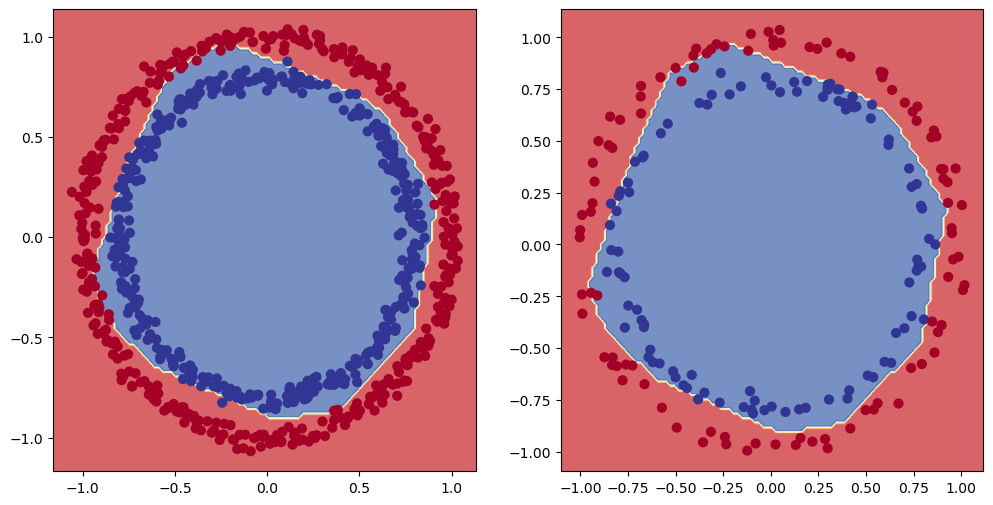

In [113]:
from helper_functions import *
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_2,X_train,Y_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_2,X_test,Y_test)


### Multi Class Problem - Using Non-linear

In [2]:
from sklearn.datasets import make_blobs
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
X_blob,Y_blob=make_blobs(1000,n_features=2,centers=4,cluster_std=1.5,random_state=42)
(X_blob.shape),(Y_blob[:5])

((1000, 2), array([3, 2, 2, 1, 1]))

In [4]:
device='cuda' if torch.cuda.is_available() else 'mps'

In [5]:
X_blob_train,X_blob_test,Y_blob_train,Y_blob_test=train_test_split(X_blob,Y_blob,test_size=0.2,random_state=42)

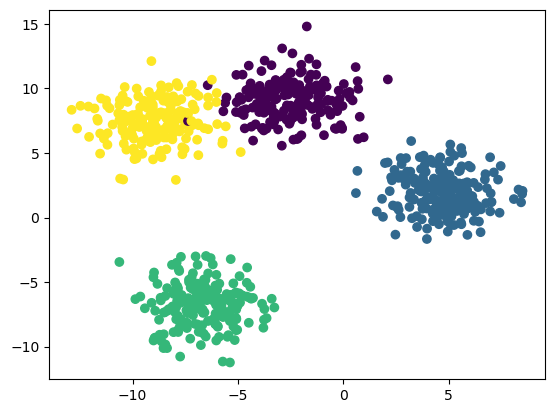

In [6]:
plt.scatter(X_blob_train[:,0],X_blob_train[:,1],c=Y_blob_train)
plt.show()

In [7]:
Y_blob_train=torch.from_numpy(Y_blob_train).type(torch.LongTensor).to(device)
Y_blob_test=torch.from_numpy(Y_blob_test).type(torch.LongTensor).to(device)

In [8]:
loop=['X_blob_train','X_blob_test']
for l in loop:
    m=locals()[l]
    if isinstance(m, np.ndarray):
        locals()[l]=torch.from_numpy(m).type(torch.float).to(device)
X_blob_train.device

device(type='mps', index=0)

In [9]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=correct*100/len(y_true)
    return acc

In [10]:
class BlobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=10):
        super().__init__()
        self.linear_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    def forward(self,x):
        return self.linear_stack(x)

model_4=BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_4

BlobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [11]:
next(model_4.parameters()).device

device(type='mps', index=0)

In [12]:
y_logits=model_4(X_blob_test)
y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
y_pred[:5]

tensor([3, 3, 1, 3, 3], device='mps:0')

In [13]:
Y_blob_test[:5]

tensor([1, 3, 2, 1, 0], device='mps:0')

In [14]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [16]:
EPOCHS=1000
for epoch in range(EPOCHS):
    model_4.train()
    pred_l=model_4(X_blob_train)
    pred_t=torch.softmax(pred_l,dim=1).argmax(dim=1)
    acc=accuracy_fn(Y_blob_train,pred_t)
    loss=loss_fn(pred_l,Y_blob_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch%100==0):
        model_4.eval()
        with torch.inference_mode():
            pred_lt=model_4(X_blob_test)
        losst=loss_fn(pred_lt,Y_blob_test)
        pred_tt=torch.softmax(pred_lt,dim=1).argmax(dim=1)
        acct=accuracy_fn(Y_blob_test,pred_tt)
        print(f'Train Loss: {loss}, Train Acc:{acc} | Test Loss:{losst}, Test Accuracy{acct}')
        

Train Loss: 0.9367951154708862, Train Acc:72.875 | Test Loss:0.8754850625991821, Test Accuracy75.0
Train Loss: 0.05154207721352577, Train Acc:98.875 | Test Loss:0.04838739335536957, Test Accuracy99.0
Train Loss: 0.03351598605513573, Train Acc:99.0 | Test Loss:0.026754753664135933, Test Accuracy99.0
Train Loss: 0.029783954843878746, Train Acc:99.0 | Test Loss:0.020453820005059242, Test Accuracy99.5
Train Loss: 0.028223371133208275, Train Acc:99.0 | Test Loss:0.01776254177093506, Test Accuracy99.5
Train Loss: 0.02740336023271084, Train Acc:99.125 | Test Loss:0.016441024839878082, Test Accuracy99.5
Train Loss: 0.026855893433094025, Train Acc:99.125 | Test Loss:0.015668129548430443, Test Accuracy99.5
Train Loss: 0.026430973783135414, Train Acc:99.125 | Test Loss:0.015101493336260319, Test Accuracy99.5
Train Loss: 0.02608337625861168, Train Acc:99.125 | Test Loss:0.0146323898807168, Test Accuracy99.5
Train Loss: 0.02577967941761017, Train Acc:99.125 | Test Loss:0.01424665842205286, Test Acc

In [17]:
from helper_functions import *

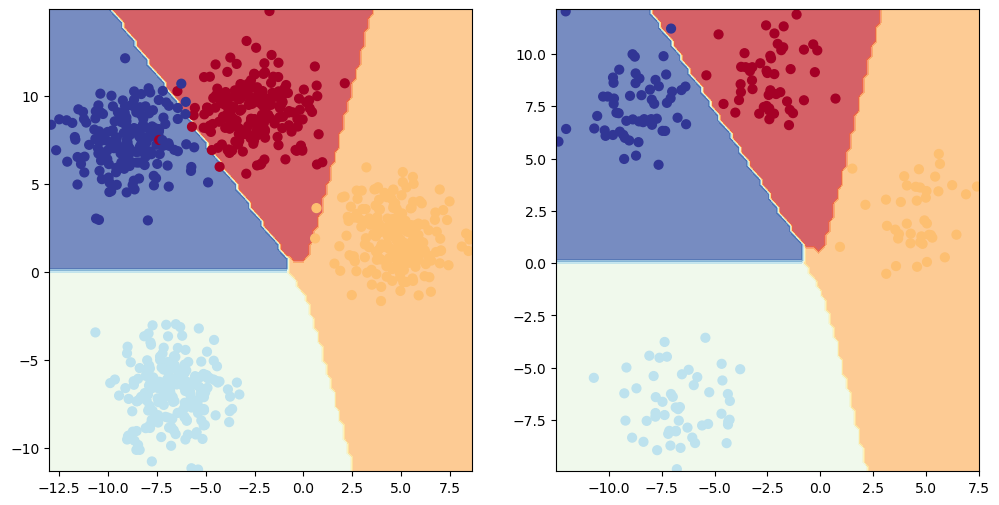

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_4,X_blob_train,Y_blob_train)
plt.subplot(1,2,2)
plot_decision_boundary(model_4,X_blob_test,Y_blob_test)
